# SRL Model

## Initialization

In [ ]:
! pip install transformers==4.40.2
! pip install datasets
! pip install seqeval
! pip install tabulate
! pip install tensorflow
! pip install keras
! pip install scikit-learn
! pip install pandas
! pip install numpy
! pip install sentencepiece
! pip install seaborn

In [ ]:
import torch
import datetime
import numpy as np
import pandas as pd
import random, time, os
from torch.nn import Embedding
from transformers import AutoTokenizer, AutoModelForTokenClassification
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from transformers import get_linear_schedule_with_warmup, pipeline
from keras.utils import pad_sequences
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

2024-12-07 13:26:46.027101: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-07 13:26:46.027162: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-07 13:26:46.027192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 13:26:46.034535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-07 13:26:46.797169: W tensorflow/compiler/

In [ ]:
configurations = {
    "default": {
        "srl_labels": ["ARG0","ARG1","ARG2","AM-MOD","AM-ADV","REL","AM-TMP","AM-CAU","AM-LOC","AM-DIR", "AM-MNR","AM-DIS","AM-PRD","ARG3","ARG4","AM-LVB","AM-PRP","AM-COM","AM-GOL","AM-EXT","AM-REC","AM-NEG","AM-ADJ"],
        "verb_labels": ["B-VBE", "B-VBI", "B-VBL", "B-VBP", "B-VBT"],
        "seed_val": 43,
        "max_len": 256,
        "info_every": 30,
        "gradient_clip": 1.0,
        "gozali_data_location": "data/srl_corpus_gojali.txt"
    },
    "xlmr_english": {
      "model": "FacebookAI/xlm-roberta-large",
      "batch_size": 64,
      "epochs": 4,
      "learning_rate": 1e-4,
      "model_location": "model/srl/english",
      "load_model_location": "model/srl/english",
    },
    "xlmr_16": {
      "model": "FacebookAI/xlm-roberta-large",
      "batch_size": 16,
      "epochs": 8,
      "learning_rate": 1e-4,
      "model_location": "model/srl/ind_16",
      "load_model_location": "model/srl/ind_16",
    },
    "xlmr_32": {
      "model": "FacebookAI/xlm-roberta-large",
      "batch_size": 32,
      "epochs": 8,
      "learning_rate": 1e-4,
      "model_location": "model/srl/ind_32",
      "load_model_location": "model/srl/ind_32",
    },
}

In [3]:
seed_val = configurations["default"]["seed_val"]
device = "cuda"
LongTensor = torch.LongTensor
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
class MatrixModel():
    def __init__(self):
        self.arg_excess = defaultdict(int)
        self.arg_missed = defaultdict(int)
        self.arg_match = defaultdict(int)

    def filter_label(self, text, gold_labels, pred_labels):
        new_gold_labels, new_pred_labels = [], []
        for i in range(len(text)):
            if text[i].startswith("▁"):
                new_gold_labels.append(gold_labels[i])
                new_pred_labels.append(pred_labels[i])
            else:
                continue
        return new_gold_labels, new_pred_labels

    def evaluate_tagset(self, text, gold_labels, pred_labels):
        new_gold_labels, new_pred_labels = self.filter_label(text, gold_labels, pred_labels)
        label_filter = ["O"]
        gld = set([f"{i}_{y}" for i, y in enumerate(new_gold_labels) if y not in label_filter])
        sys = set([f"{i}_{y}" for i, y in enumerate(new_pred_labels) if y not in label_filter])

        excess = sys - gld  # False Positives
        missed = gld - sys  # False Negatives
        true_pos = sys.intersection(gld)

        eval_obj = {"excess": [x.split("_")[1][2:] for x in excess],
                    "missed": [x.split("_")[1][2:] for x in missed],
                    "match": [x.split("_")[1][2:] for x in true_pos]}
        self.add_to_eval_dicts(eval_obj)

    def add_to_eval_dicts(self, eval_metrics):
        for arg in eval_metrics["excess"]:
            self.arg_excess[arg] += 1
        for arg in eval_metrics["missed"]:
            self.arg_missed[arg] += 1
        for arg in eval_metrics["match"]:
            self.arg_match[arg] += 1

    def get_metrics(self, false_pos, false_neg, true_pos):
        _denom1 = true_pos + false_pos
        precision = true_pos / _denom1 if _denom1 else 0
        _denom2 = true_pos + false_neg
        recall = true_pos / _denom2 if _denom2 else 0
        _denom3 = precision + recall
        F1 = 2 * ((precision * recall) / _denom3) if _denom3 else 0
        return precision*100, recall*100, F1*100

    def show_overall_metrics(self, save_to_file=None, print_metrics=True):
        processed_args = set()
        results = []
        tot_excess, tot_missed, tot_match = 0, 0, 0
        for arg, count in self.arg_match.items():
            excess = self.arg_excess.get(arg, 0)
            missed = self.arg_missed.get(arg, 0)
            p,r,f = self.get_metrics(false_pos=excess, false_neg=missed, true_pos=count)
            processed_args.add(arg)
            results.append((arg, count, excess, missed, p, r, f))
            tot_excess += excess
            tot_missed += missed
            tot_match += count
        for arg, count in self.arg_excess.items():
            if arg not in processed_args:
                excess = count
                missed = self.arg_missed.get(arg, 0)
                correct = self.arg_match.get(arg, 0)
                p, r, f = self.get_metrics(false_pos=excess, false_neg=missed, true_pos=correct) # p,r,f = 0,0,0
                processed_args.add(arg)
                results.append((arg, correct, excess, missed, p, r, f))
                tot_excess += excess
                tot_missed += missed
                tot_match += correct
        for arg, count in self.arg_missed.items():
            if arg not in processed_args:
                excess = self.arg_excess.get(arg, 0)
                correct = self.arg_match.get(arg, 0)
                missed = count
                p, r, f = self.get_metrics(false_pos=excess, false_neg=missed, true_pos=correct) # p,r,f = 0,0,0
                results.append((arg, correct, excess, missed, p, r, f))
                tot_excess += excess
                tot_missed += missed
                tot_match += correct
        results = sorted(results, key= lambda x: x[0])

        prec, rec, F1 = self.get_metrics(false_pos=tot_excess, false_neg=tot_missed, true_pos=tot_match)

        if print_metrics:
            print("\n--- OVERALL ---\nCorrect: {0}\tExcess: {1}\tMissed: {2}\nPrecision: {3:.2f}\t\tRecall: {4:.2f}\nF1: {5:.2f}\n".format(tot_match, tot_excess, tot_missed, prec, rec, F1))
            print(tabulate(results, headers=["corr.", "excess", "missed", "prec.", "rec.", "F1"], floatfmt=".2f"))
        if save_to_file:
            fout = open(save_to_file, "w")
            fout.write("\n--- OVERALL ---\nCorrect: {0}\tExcess: {1}\tMissed: {2}\nPrecision: {3:.2f}\t\tRecall: {4:.2f}\nF1: {5:.2f}\n".format(tot_match, tot_excess, tot_missed, prec, rec, F1))
            fout.write(tabulate(results, headers=["corr.", "excess", "missed", "prec.", "rec.", "F1"], floatfmt=".2f"))

## Preprocessing

### ConLL-2012 Data

In [6]:
class EnglishDataset():
    def __init__(self):
        self.dataset = load_dataset("conll2012_ontonotesv5", "english_v12",  cache_dir="./cache")

    def change_arg_srl(self, arg):
        new_arg = arg[:]
        for i in range (len(new_arg)):
            if new_arg[i] == "B-V":
                new_arg[i] = "B-REL"
            if "ARGM" in new_arg[i]:
                new_arg[i] = new_arg[i].replace("ARGM", "AM")
            if new_arg[i]!= "O":
                label = new_arg[i][2:]
                if label not in configurations["default"]["srl_labels"]:
                    new_arg[i] = "O"
        return new_arg

    def get_srl_data(self, dataset):
        srl_data = []
        row, col = dataset.shape
        for i in range(col):
            for j in range(row):
                data = dataset[i][j]
                if data is not None and len(data["srl_frames"]) != 0:
                    for frame in data["srl_frames"]:
                        new_frame = self.change_arg_srl(frame["frames"])
                        srl = {
                            "words" : data["words"],
                            "arguments" : new_frame,
                            "predicate" : frame["verb"]
                        }
                        srl_data.append(srl)
        return srl_data

    def get_all_data_english(self):
        train_sentences = pd.DataFrame(self.dataset["train"]["sentences"])
        val_sentences = pd.DataFrame(self.dataset["validation"]["sentences"])
        test_sentences = pd.DataFrame(self.dataset["test"]["sentences"])
        train_srl = self.get_srl_data(train_sentences)
        val_srl = self.get_srl_data(val_sentences)
        test_srl = self.get_srl_data(test_sentences)
        return train_srl, val_srl, test_srl

In [7]:
english_dataset = EnglishDataset()
train_english_data, val_english_data, test_english_data = english_dataset.get_all_data_english()

In [7]:
len(train_english_data), len(val_english_data), len(test_english_data)

(253070, 35297, 26715)

### Gozali Data

In [5]:
class GozaliDataset():
    def __init__(self):
        self.data_path = configurations["default"]["gozali_data_location"]
        self.random_state = configurations["default"]["seed_val"]

    def split_first(self, data, separator):
        arr = data.split(separator)
        first = arr[0]
        rest = arr[1:]
        return first, rest

    def read_gozali_data(self):
        try:
            file = open(self.data_path, encoding='utf-16')
            lines = file.readlines()
        except:
            file = open(self.data_path)
            lines = file.readlines()
        srl_data = []
        for pairs in lines:
            sent, pasList = self.split_first(pairs, ';')
            data_word = sent.split(" ")
            for arg in pasList:
                data_arg = arg.strip().split(" ")
                if "[" in data_word:
                    first_idx, last_idx = data_word.index("["), data_word.index("]")
                    data_word[first_idx] = "("
                    data_word[last_idx] = ")"
                index_verb = data_arg.index("B-REL")
                srl = {
                "words" : data_word,
                "arguments" : data_arg,
                "predicate" : data_word[index_verb]
                }
                srl_data.append(srl)
        return srl_data

    def get_all_data_gozali(self):
        dataset = self.read_gozali_data()
        train_srl, test_srl = train_test_split(dataset, random_state=self.random_state, test_size=0.4)
        val_srl, test_srl = train_test_split(test_srl, random_state=self.random_state, test_size=0.5)
        return train_srl, val_srl, test_srl


In [6]:
gozali_dataset = GozaliDataset()
train_gozali_data, val_gozali_data, test_gozali_data = gozali_dataset.get_all_data_gozali()

In [7]:
len(train_gozali_data), len(val_gozali_data), len(test_gozali_data)

(4000, 1333, 1334)

## Modeling

In [ ]:
class TransformerModel():
    def __init__(self, config):
        self.name = config["model"]
        self.batch_size = config["batch_size"]
        self.epochs = config["epochs"]
        self.learning_rate = config["learning_rate"]
        self.save_location_model = config["model_location"]
        self.tokenizer: AutoTokenizer = None
        self.model: AutoModelForTokenClassification = None

    def build_label_vocab(self) -> dict:
        label2index = {"O": 0}
        for j in range(2):
          tag = "B-" if j==0 else "I-"
          for labelset in configurations["default"]["srl_labels"]:
            if labelset not in label2index:
              label2index[tag+labelset] = len(label2index)
        return label2index

    def create_model(self):
        label2index = self.build_label_vocab()
        index2label = {v: k for k, v in label2index.items()}
        self.tokenizer = AutoTokenizer.from_pretrained(self.name, cache_dir="./cache")
        self.model = AutoModelForTokenClassification.from_pretrained(self.name, num_labels=len(label2index), cache_dir="./cache")
        self.model.config.finetuning_task = 'token-classification'
        self.model.config.id2label = index2label
        self.model.config.label2id = label2index
        self.model.config.type_vocab_size = 2
        # Create a new Embeddings layer, with 2 possible segments IDs instead of 1
        self.model.roberta.embeddings.token_type_embeddings = Embedding(2, self.model.config.hidden_size)
        self.model.roberta.embeddings.token_type_embeddings.weight.data.normal_(mean=0.0, std=self.model.config.initializer_range)
        self.model.to(device)

    def load_model(self, model_dir):
        self.model = AutoModelForTokenClassification.from_pretrained(model_dir)
        self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
        self.model.to(device)

    def expand_label_token(self, original_sentence, original_labels):
        tmp_labels = []
        txt_sentences = " ".join(original_sentence)
        tokens = self.tokenizer(txt_sentences, padding="max_length", truncation=True, max_length=configurations["default"]["max_len"])
        sentence = self.tokenizer.tokenize(txt_sentences)
        for i, word in enumerate(original_sentence):
            word_pieces = self.tokenizer.tokenize(word)
            if len(word_pieces) == 1:
                tmp_labels.append(original_labels[i])
            else:
                tmp_labels.append(original_labels[i])
                for _ in range (1, len(word_pieces)):
                    if original_labels[i] == "O":
                        tmp_labels.append("O")
                    else:
                        tmp_labels.append("I" + original_labels[i][1:])
        labels = ["O"] + tmp_labels + ["O"]
        length = len(sentence)+2
        return tokens, labels, length

    def get_data(self, data):
        list_input_ids, verb_indicators, all_labels, attention_masks, length_sentences = [], [], [], [], []
        for _, obj in enumerate(data):
            tokens, labelset, length_sentence = self.expand_label_token(obj["words"], obj["arguments"])
            input_ids = tokens["input_ids"]
            attent_mask = tokens["attention_mask"]
            list_input_ids.append(input_ids)
            attention_masks.append(attent_mask)
            length_sentences.append(length_sentence)
            # Verb Indicator (which predicate to label)
            bio_verb = [1 if label[2:] == "REL" else 0 for label in labelset]
            verb_indicators.append(bio_verb)
            all_labels.append(labelset)

        return list_input_ids, verb_indicators, all_labels, attention_masks, length_sentences

    def load_srl_dataset(self, data):
        input_ids, verb_indicators, labels, attention_masks, seq_lengths = self.get_data(data)
        label_ixs = []
        label2index = self.build_label_vocab()
        # Convert label to their indices
        for i, labelset in enumerate(labels):
            label_ixs.append([label2index.get(l, 1) for l in labelset])
        # pad label and verb consequence
        input_is_pred = pad_sequences(verb_indicators, maxlen=configurations["default"]["max_len"], dtype="long", value=0, truncating="post", padding="post")
        label_ids = pad_sequences(label_ixs, maxlen=configurations["default"]["max_len"], dtype="long", value=0, truncating="post", padding="post")
        label_ids = LongTensor(label_ids)
        return LongTensor(input_ids), LongTensor(attention_masks), label_ids,  LongTensor(seq_lengths), LongTensor(input_is_pred)

    def create_train_val_dataloader(self, train_data, val_data):
        train_inputs, train_masks, train_labels, _, train_preds = self.load_srl_dataset(train_data)
        # Create the DataLoader for training set.
        train_data = TensorDataset(train_inputs, train_masks, train_labels, train_preds)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)
        val_inputs, val_masks, val_labels, _, val_preds = self.load_srl_dataset(val_data)
        # Create the DataLoader for validation set
        val_data = TensorDataset(val_inputs, val_masks, val_labels, val_preds)
        val_sampler = RandomSampler(val_data)
        val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=self.batch_size)
        return train_dataloader, val_dataloader

    def create_pred_dataloader(self, data):
        prediction_inputs, prediction_masks, gold_labels, seq_lens, gold_predicates = self.load_srl_dataset(data)
        # Create the DataLoader.
        prediction_data = TensorDataset(prediction_inputs, prediction_masks, gold_labels, seq_lens, gold_predicates)
        prediction_sampler = SequentialSampler(prediction_data)
        prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=self.batch_size)
        return prediction_dataloader


### XLM-R

In [ ]:
# large english model with english data
xlmr_large_model_english = TransformerModel(configurations["xlmr_english"])
xlmr_large_model_english.create_model()

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# large english model with gozali data 16 batch
xlmr_large_english_model_gozali_16 = TransformerModel(configurations["xlmr_16"])
xlmr_large_english_model_gozali_16.load_model(configurations["xlmr_english"]["load_model_location"])

In [ ]:
# large english model with gozali data 32 batch
xlmr_large_english_model_gozali_32 = TransformerModel(configurations["xlmr_32"])
xlmr_large_english_model_gozali_32.load_model(configurations["xlmr_english"]["load_model_location"])

## Training

In [ ]:
class TrainerModel():
    def __init__(self, model):
        self.transformer_model: TransformerModel = model
        self.save_path = model.save_location_model
        self.pad_token_label_id = CrossEntropyLoss().ignore_index
        self.matrix_model = None

    def format_time(self, elapsed):
        # Round to the nearest second.
        elapsed_rounded = int(round((elapsed)))
        return str(datetime.timedelta(seconds=elapsed_rounded))

    def save_model(self, path, arg_dict, model, tokenizer):
        # Create output directory if needed
        if not os.path.exists(path):
            os.makedirs(path)
        print("Saving model to %s" % path)
        model_to_save = model.module if hasattr(model, 'module') else model
        model_to_save.save_pretrained(path)
        tokenizer.save_pretrained(path)
        torch.save(arg_dict, os.path.join(path, 'training_args.bin'))

    def evaluate_model(self, val_dataloader, label_map: dict):
        print("***** Running evaluation Validation Set *****")
        print(f"  Batch size = {self.transformer_model.batch_size}")
        self.matrix_model = MatrixModel()
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        input_ids, gold_label_ids = None, None
        self.transformer_model.model.eval()
        for batch in val_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels, b_preds = batch

            with torch.no_grad():
                outputs = self.transformer_model.model(b_input_ids, token_type_ids=b_preds, attention_mask=b_input_mask, labels=b_labels)
                tmp_eval_loss, logits = outputs[:2]
                eval_loss += tmp_eval_loss.item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                gold_label_ids = b_labels.detach().cpu().numpy()
                input_ids = b_input_ids.detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                gold_label_ids = np.append(gold_label_ids, b_labels.detach().cpu().numpy(), axis=0)
                input_ids = np.append(input_ids, b_input_ids.detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        preds = np.argmax(preds, axis=2)

        gold_label_list = [[] for _ in range(gold_label_ids.shape[0])]
        pred_label_list = [[] for _ in range(gold_label_ids.shape[0])]

        for seq_ix in range(gold_label_ids.shape[0]):
            for j in range(gold_label_ids.shape[1]):
                if gold_label_ids[seq_ix, j] != self.pad_token_label_id:
                    gold_label_list[seq_ix].append(label_map[gold_label_ids[seq_ix][j]])
                    pred_label_list[seq_ix].append(label_map[preds[seq_ix][j]])
            text = self.transformer_model.tokenizer.convert_ids_to_tokens(input_ids[seq_ix], skip_special_tokens=True)
            # Delete unnecessary label
            pred_label = pred_label_list[seq_ix][1:len(text)+1]
            gold_label = gold_label_list[seq_ix][1:len(text)+1]
            self.matrix_model.evaluate_tagset(text, gold_label, pred_label)
        print("Validation Loss: {}\n".format(eval_loss))
        self.matrix_model.show_overall_metrics()

    def start_train(self, train_data, val_data):
        train_dataloader, val_dataloader = self.transformer_model.create_train_val_dataloader(train_data, val_data)
        # Total number of training steps is number of batches * number of epochs.
        total_steps = len(train_dataloader) * self.transformer_model.epochs

        optimizer = AdamW(self.transformer_model.model.parameters(), lr=self.transformer_model.learning_rate, eps=1e-8)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
        model = self.transformer_model.model
        label2index = self.transformer_model.build_label_vocab()
        index2label = {v: k for k, v in label2index.items()}

        loss_values = []
        # For each epoch...
        for epoch_i in range(self.transformer_model.epochs):
            # Perform one full pass over the training set.
            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i+1, self.transformer_model.epochs))
            print('Training...')

            t0 = time.time()
            total_loss = 0
            model.train()

            # For each batch of training data...
            for step, batch in enumerate(train_dataloader):
                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                b_predicates = batch[3].to(device)

                model.zero_grad()

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, token_type_ids=b_predicates, attention_mask=b_input_mask, labels=b_labels)
                loss = outputs[0]
                total_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Clip the norm of the gradients to 1.0.
                torch.nn.utils.clip_grad_norm_(model.parameters(), configurations["default"]["gradient_clip"])

                # Update parameters
                optimizer.step()
                scheduler.step()

                # Progress update
                if step % configurations["default"]["info_every"] == 0 and step != 0:
                    # Calculate elapsed time in minutes.
                    elapsed = self.format_time(time.time() - t0)
                    # Report progress.
                    print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.    Loss: {}.'.format(step, len(train_dataloader),
                                                                                                    elapsed, loss.item()))

            # Calculate the average loss over the training data.
            avg_train_loss = total_loss / len(train_dataloader)

            # Store the loss value for plotting the learning curve.
            loss_values.append(avg_train_loss)

            print("")
            print("  Average training loss: {0:.4f}".format(avg_train_loss))
            print("  Training Epoch took: {:}".format(self.format_time(time.time() - t0)))

            # evaluate model
            t0 = time.time()
            self.evaluate_model(val_dataloader, index2label)
            print("  Validation took: {:}".format(self.format_time(time.time() - t0)))


            # save checkpoint
            self.save_model(f"{self.save_path}/EPOCH_{epoch_i+1}", {"args":[]}, model, self.transformer_model.tokenizer)

### XLM-R

In [ ]:
# large model with english data
xlmr_large_trainer_english = TrainerModel(xlmr_large_model_english)
xlmr_large_trainer_english.start_train(train_english_data, val_english_data)

/tmp/ipykernel_761793/2878866535.py:119: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  label_ids = LongTensor(label_ids)



======== Epoch 1 / 4 ========
Training...
  Batch    30  of  3,955.    Elapsed: 0:00:57.    Loss: 0.21031519770622253.
  Batch    60  of  3,955.    Elapsed: 0:01:52.    Loss: 0.1709040105342865.
  Batch    90  of  3,955.    Elapsed: 0:02:46.    Loss: 0.18046113848686218.
  Batch   120  of  3,955.    Elapsed: 0:03:40.    Loss: 0.16578981280326843.
  Batch   150  of  3,955.    Elapsed: 0:04:35.    Loss: 0.13930025696754456.
  Batch   180  of  3,955.    Elapsed: 0:05:29.    Loss: 0.1254076212644577.
  Batch   210  of  3,955.    Elapsed: 0:06:23.    Loss: 0.09505768120288849.
  Batch   240  of  3,955.    Elapsed: 0:07:18.    Loss: 0.09153497219085693.
  Batch   270  of  3,955.    Elapsed: 0:08:12.    Loss: 0.09027732163667679.
  Batch   300  of  3,955.    Elapsed: 0:09:06.    Loss: 0.07725603133440018.
  Batch   330  of  3,955.    Elapsed: 0:10:01.    Loss: 0.08220823854207993.
  Batch   360  of  3,955.    Elapsed: 0:10:55.    Loss: 0.07971430569887161.
  Batch   390  of  3,955.    Elapse

  Batch 3,210  of  3,955.    Elapsed: 1:36:59.    Loss: 0.030369441956281662.
  Batch 3,240  of  3,955.    Elapsed: 1:37:54.    Loss: 0.048867832869291306.
  Batch 3,270  of  3,955.    Elapsed: 1:38:48.    Loss: 0.030092205852270126.
  Batch 3,300  of  3,955.    Elapsed: 1:39:42.    Loss: 0.047199610620737076.
  Batch 3,330  of  3,955.    Elapsed: 1:40:37.    Loss: 0.04262375831604004.
  Batch 3,360  of  3,955.    Elapsed: 1:41:31.    Loss: 0.03629538044333458.
  Batch 3,390  of  3,955.    Elapsed: 1:42:26.    Loss: 0.044858478009700775.
  Batch 3,420  of  3,955.    Elapsed: 1:43:20.    Loss: 0.03243463858962059.
  Batch 3,450  of  3,955.    Elapsed: 1:44:14.    Loss: 0.04002398997545242.
  Batch 3,480  of  3,955.    Elapsed: 1:45:09.    Loss: 0.04272822290658951.
  Batch 3,510  of  3,955.    Elapsed: 1:46:03.    Loss: 0.03468393161892891.
  Batch 3,540  of  3,955.    Elapsed: 1:46:57.    Loss: 0.05418533459305763.
  Batch 3,570  of  3,955.    Elapsed: 1:47:52.    Loss: 0.0211006347090

In [ ]:
# large model with english data
xlmr_large_trainer_english = TrainerModel(xlmr_large_model_english)
xlmr_large_trainer_english.start_train(train_english_data, val_english_data)


======== Epoch 2 / 3 ========
Training...
  Batch    30  of  3,955.    Elapsed: 0:00:57.    Loss: 0.02829318307340145.
  Batch    60  of  3,955.    Elapsed: 0:01:51.    Loss: 0.04228596016764641.
  Batch    90  of  3,955.    Elapsed: 0:02:46.    Loss: 0.024088965728878975.
  Batch   120  of  3,955.    Elapsed: 0:03:40.    Loss: 0.03263706713914871.
  Batch   150  of  3,955.    Elapsed: 0:04:34.    Loss: 0.04749066382646561.
  Batch   180  of  3,955.    Elapsed: 0:05:29.    Loss: 0.021888041868805885.
  Batch   210  of  3,955.    Elapsed: 0:06:23.    Loss: 0.024053389206528664.
  Batch   240  of  3,955.    Elapsed: 0:07:18.    Loss: 0.04676789045333862.
  Batch   270  of  3,955.    Elapsed: 0:08:12.    Loss: 0.02507045306265354.
  Batch   300  of  3,955.    Elapsed: 0:09:06.    Loss: 0.048698894679546356.
  Batch   330  of  3,955.    Elapsed: 0:10:01.    Loss: 0.02872643806040287.
  Batch   360  of  3,955.    Elapsed: 0:10:55.    Loss: 0.024888798594474792.
  Batch   390  of  3,955.   

  Batch 3,300  of  3,955.    Elapsed: 1:39:49.    Loss: 0.031341392546892166.
  Batch 3,330  of  3,955.    Elapsed: 1:40:43.    Loss: 0.028822150081396103.
  Batch 3,360  of  3,955.    Elapsed: 1:41:37.    Loss: 0.014788053929805756.
  Batch 3,390  of  3,955.    Elapsed: 1:42:32.    Loss: 0.03201240673661232.
  Batch 3,420  of  3,955.    Elapsed: 1:43:26.    Loss: 0.028481759130954742.
  Batch 3,450  of  3,955.    Elapsed: 1:44:21.    Loss: 0.028022345155477524.
  Batch 3,480  of  3,955.    Elapsed: 1:45:15.    Loss: 0.028672028332948685.
  Batch 3,510  of  3,955.    Elapsed: 1:46:10.    Loss: 0.017787812277674675.
  Batch 3,540  of  3,955.    Elapsed: 1:47:04.    Loss: 0.04396757483482361.
  Batch 3,570  of  3,955.    Elapsed: 1:47:59.    Loss: 0.030530286952853203.
  Batch 3,600  of  3,955.    Elapsed: 1:48:53.    Loss: 0.03885825350880623.
  Batch 3,630  of  3,955.    Elapsed: 1:49:47.    Loss: 0.0479075163602829.
  Batch 3,660  of  3,955.    Elapsed: 1:50:42.    Loss: 0.03087203390

In [11]:
# large model with english data
xlmr_large_trainer_english = TrainerModel(xlmr_large_model_english)
xlmr_large_trainer_english.start_train(train_english_data, val_english_data)


======== Epoch 3 / 4 ========
Training...
  Batch    30  of  3,955.    Elapsed: 0:00:57.    Loss: 0.01880718767642975.
  Batch    60  of  3,955.    Elapsed: 0:01:52.    Loss: 0.0284088384360075.
  Batch    90  of  3,955.    Elapsed: 0:02:46.    Loss: 0.023929044604301453.
  Batch   120  of  3,955.    Elapsed: 0:03:40.    Loss: 0.02987511456012726.
  Batch   150  of  3,955.    Elapsed: 0:04:35.    Loss: 0.027369583025574684.
  Batch   180  of  3,955.    Elapsed: 0:05:29.    Loss: 0.016684968024492264.
  Batch   210  of  3,955.    Elapsed: 0:06:24.    Loss: 0.02341388165950775.
  Batch   240  of  3,955.    Elapsed: 0:07:18.    Loss: 0.03798419237136841.
  Batch   270  of  3,955.    Elapsed: 0:08:12.    Loss: 0.025885576382279396.
  Batch   300  of  3,955.    Elapsed: 0:09:07.    Loss: 0.03400200977921486.
  Batch   330  of  3,955.    Elapsed: 0:10:01.    Loss: 0.021381931379437447.
  Batch   360  of  3,955.    Elapsed: 0:10:56.    Loss: 0.02737625315785408.
  Batch   390  of  3,955.    

  Batch 3,210  of  3,955.    Elapsed: 1:37:06.    Loss: 0.018575703725218773.
  Batch 3,240  of  3,955.    Elapsed: 1:38:00.    Loss: 0.020187558606266975.
  Batch 3,270  of  3,955.    Elapsed: 1:38:55.    Loss: 0.029655039310455322.
  Batch 3,300  of  3,955.    Elapsed: 1:39:49.    Loss: 0.031032748520374298.
  Batch 3,330  of  3,955.    Elapsed: 1:40:44.    Loss: 0.029546482488512993.
  Batch 3,360  of  3,955.    Elapsed: 1:41:38.    Loss: 0.010626604780554771.
  Batch 3,390  of  3,955.    Elapsed: 1:42:32.    Loss: 0.02251501753926277.
  Batch 3,420  of  3,955.    Elapsed: 1:43:27.    Loss: 0.014212590642273426.
  Batch 3,450  of  3,955.    Elapsed: 1:44:22.    Loss: 0.021716251969337463.
  Batch 3,480  of  3,955.    Elapsed: 1:45:16.    Loss: 0.01943705789744854.
  Batch 3,510  of  3,955.    Elapsed: 1:46:11.    Loss: 0.01368525717407465.
  Batch 3,540  of  3,955.    Elapsed: 1:47:05.    Loss: 0.04448346793651581.
  Batch 3,570  of  3,955.    Elapsed: 1:47:59.    Loss: 0.0261002723

  Batch 1,740  of  3,955.    Elapsed: 0:52:39.    Loss: 0.038599636405706406.
  Batch 1,770  of  3,955.    Elapsed: 0:53:34.    Loss: 0.022397136315703392.
  Batch 1,800  of  3,955.    Elapsed: 0:54:28.    Loss: 0.01547984592616558.
  Batch 1,830  of  3,955.    Elapsed: 0:55:23.    Loss: 0.023645078763365746.
  Batch 1,860  of  3,955.    Elapsed: 0:56:17.    Loss: 0.014900058507919312.
  Batch 1,890  of  3,955.    Elapsed: 0:57:11.    Loss: 0.021593647077679634.
  Batch 1,920  of  3,955.    Elapsed: 0:58:06.    Loss: 0.014287999831140041.
  Batch 1,950  of  3,955.    Elapsed: 0:59:00.    Loss: 0.022590626031160355.
  Batch 1,980  of  3,955.    Elapsed: 0:59:55.    Loss: 0.01726498268544674.
  Batch 2,010  of  3,955.    Elapsed: 1:00:49.    Loss: 0.017915990203619003.
  Batch 2,040  of  3,955.    Elapsed: 1:01:44.    Loss: 0.02147800847887993.
  Batch 2,070  of  3,955.    Elapsed: 1:02:38.    Loss: 0.010308978147804737.
  Batch 2,100  of  3,955.    Elapsed: 1:03:32.    Loss: 0.020126376

In [ ]:
# large english model with gozali data 32 batch
xlmr_large_english_trainer_gozali_32 = TrainerModel(xlmr_large_english_model_gozali_32)
xlmr_large_english_trainer_gozali_32.start_train(train_gozali_data, val_gozali_data)


======== Epoch 1 / 8 ========
Training...
  Batch    30  of    125.    Elapsed: 0:00:30.    Loss: 0.039868779480457306.
  Batch    60  of    125.    Elapsed: 0:00:59.    Loss: 0.053672291338443756.
  Batch    90  of    125.    Elapsed: 0:01:27.    Loss: 0.03191253915429115.
  Batch   120  of    125.    Elapsed: 0:01:56.    Loss: 0.023709924891591072.

  Average training loss: 0.0373
  Training Epoch took: 0:02:00
***** Running evaluation Validation Set *****
  Batch size = 32
Validation Loss: 0.025566109633516697


--- OVERALL ---
Correct: 11565	Excess: 1622	Missed: 1515
Precision: 87.70		Recall: 88.42
F1: 88.06

          corr.    excess    missed    prec.    rec.     F1
------  -------  --------  --------  -------  ------  -----
AM-ADJ        0         0         2     0.00    0.00   0.00
AM-ADV      246        71        52    77.60   82.55  80.00
AM-CAU      305        36        26    89.44   92.15  90.77
AM-COM       42        16        23    72.41   64.62  68.29
AM-DIR       26   

In [ ]:
# large english model with gozali data 16 batch
xlmr_large_english_trainer_gozali_16 = TrainerModel(xlmr_large_english_model_gozali_16)
xlmr_large_english_trainer_gozali_16.start_train(train_gozali_data, val_gozali_data)


======== Epoch 1 / 8 ========
Training...
  Batch    30  of    250.    Elapsed: 0:00:17.    Loss: 0.018753401935100555.
  Batch    60  of    250.    Elapsed: 0:00:32.    Loss: 0.036014679819345474.
  Batch    90  of    250.    Elapsed: 0:00:48.    Loss: 0.05634274706244469.
  Batch   120  of    250.    Elapsed: 0:01:03.    Loss: 0.06522839516401291.
  Batch   150  of    250.    Elapsed: 0:01:19.    Loss: 0.06450467556715012.
  Batch   180  of    250.    Elapsed: 0:01:34.    Loss: 0.03858917951583862.
  Batch   210  of    250.    Elapsed: 0:01:50.    Loss: 0.01538537535816431.
  Batch   240  of    250.    Elapsed: 0:02:05.    Loss: 0.03506961837410927.

  Average training loss: 0.0393
  Training Epoch took: 0:02:10
***** Running evaluation Validation Set *****
  Batch size = 16
Validation Loss: 0.028645558349256004


--- OVERALL ---
Correct: 11347	Excess: 1913	Missed: 1733
Precision: 85.57		Recall: 86.75
F1: 86.16

          corr.    excess    missed    prec.    rec.     F1
------  ---

## Testing

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(24, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
class TesterModel():
    def __init__(self, config):
        self.model_dir = config["model_location"]
        self.pad_token_label_id = CrossEntropyLoss().ignore_index
        self.transformer_model: TransformerModel = TransformerModel(config)
        self.matrix_model = None

    def predict_data(self, test_data):
        self.matrix_model = MatrixModel()
        # Load Saved Model
        self.transformer_model.load_model(self.model_dir)
        model = self.transformer_model.model
        tokenizer =self.transformer_model.tokenizer
        label2index = self.transformer_model.build_label_vocab()
        index2label = {v: k for k, v in label2index.items()}

        # Load File for Predictions
        pred_dataloader = self.transformer_model.create_pred_dataloader(test_data)

        print(f'Predicting labels for {len(test_data)} test sentences...')

        # Put model in evaluation mode
        model.eval()

        # Tracking variables
        total_sents = 0

        list_gold_labels = []
        list_pred_labels = []

        # Predict
        for batch in pred_dataloader:
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)

            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels, b_lengths, b_preds = batch
            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=b_preds, attention_mask=b_input_mask)
            logits = outputs[0]
            class_probabilities = torch.softmax(logits, dim=-1)

            # Move class_probabilities and labels to CPU
            class_probabilities = class_probabilities.detach().cpu().numpy()
            argmax_indices = np.argmax(class_probabilities, axis=-1)

            label_ids = b_labels.to('cpu').numpy()
            seq_lengths = b_lengths.to('cpu').numpy()

            for ix in range(len(label_ids)):
                total_sents += 1
                text = tokenizer.convert_ids_to_tokens(b_input_ids[ix])
                # Store predictions and true labels
                pred_labels = [index2label[p] for p in argmax_indices[ix][:seq_lengths[ix]]]
                gold_labels = [index2label[g] for g in label_ids[ix]]
                # Delete unnecessary label
                idx_pad = text.index("<pad>")
                pred_labels = pred_labels[1:len(pred_labels)-1]
                gold_labels = gold_labels[1:idx_pad-1]
                text = text[1:idx_pad-1]
                # We have to evaluate ONLY the labels that belong to a Start WordPiece (not contain "##" or only contain "▁")
                self.matrix_model.evaluate_tagset(text, gold_labels, pred_labels)
                gold_labels, pred_labels = self.matrix_model.filter_label(text, gold_labels, pred_labels)
                print(f"\n----- {total_sents} -----\n{pred_labels}\n{gold_labels}")
                for data in gold_labels:
                    if len(data)>1:
                        list_gold_labels.append(data[2:])
                    else:
                        list_gold_labels.append(data)
                for data in pred_labels:
                    if len(data)>1:
                        list_pred_labels.append(data[2:])
                    else:
                        list_pred_labels.append(data)

        # Overall Metrics
        self.matrix_model.show_overall_metrics()
        srl_label = configurations["default"]["srl_labels"]
        srl_label.append("O")
        matrik = confusion_matrix(list_gold_labels, list_pred_labels, labels=srl_label)
        plot_confusion_matrix(matrik, srl_label)


### XLM-R

Predicting labels for 1334 test sentences...

----- 1 -----
['O', 'B-AM-LVB', 'B-REL', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'O', 'B-ARG0', 'I-ARG0', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-AM-LVB', 'B-REL', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

----- 2 -----
['B-ARG1', 'I-ARG1', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'O']
['B-ARG1', 'I-ARG1', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'B-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'O']

----- 3 -----
['B-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'O']
['B-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'O']

----- 4 -----
['B-ARG1', 'B-REL', 'O']
['B-ARG0', 'B-REL', 'O']

----- 5 -----
['B-AM-LOC', 'I-AM-LOC', 'I-AM-LOC', 'O', 'B-ARG0', 'B-REL', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'I-AR

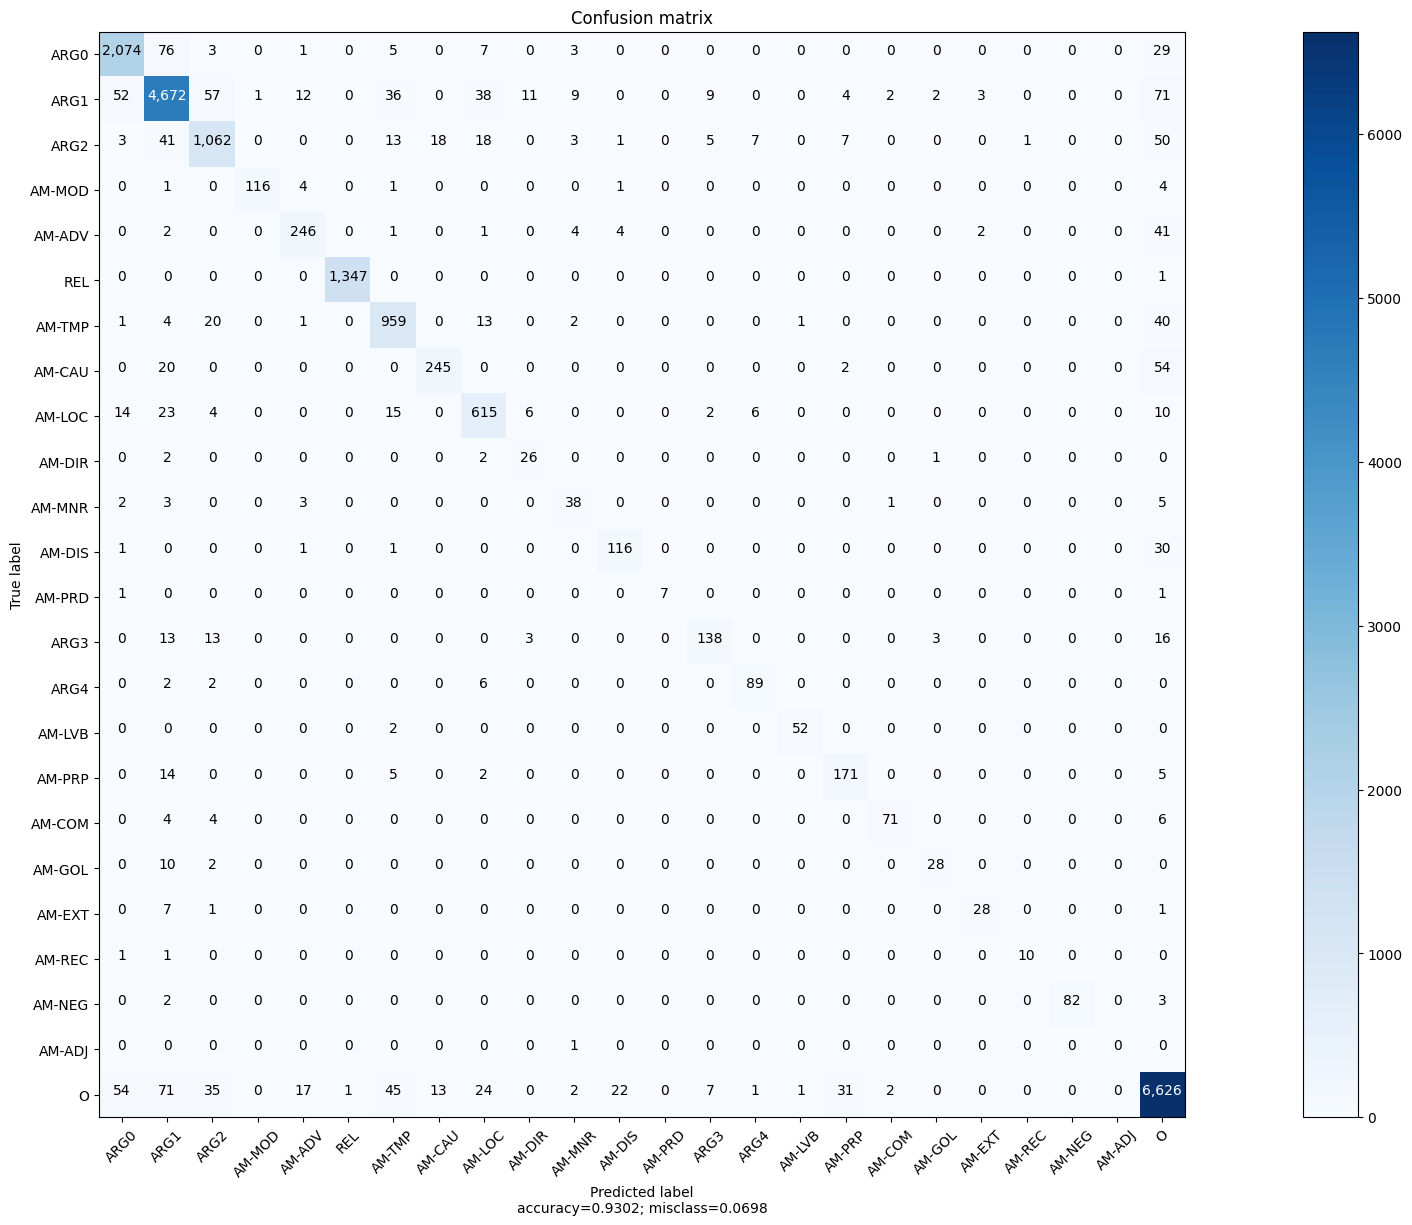

In [ ]:
# large english model with gozali data 32 batch
xlmr_large_english_32_tester = TesterModel(configurations["xlmr_32"])
xlmr_large_english_32_tester.predict_data(test_gozali_data)

Predicting labels for 1334 test sentences...

----- 1 -----
['O', 'B-AM-LVB', 'B-REL', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'O', 'B-ARG0', 'I-ARG0', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'B-AM-LVB', 'B-REL', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

----- 2 -----
['B-ARG1', 'I-ARG1', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'O']
['B-ARG1', 'I-ARG1', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'B-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'I-ARG3', 'O']

----- 3 -----
['B-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'O']
['B-ARG1', 'I-ARG1', 'O', 'O', 'O', 'O', 'B-REL', 'B-ARG2', 'I-ARG2', 'I-ARG2', 'I-ARG2', 'O']

----- 4 -----
['B-ARG0', 'B-REL', 'O']
['B-ARG0', 'B-REL', 'O']

----- 5 -----
['B-AM-LOC', 'I-AM-LOC', 'I-AM-LOC', 'O', 'B-ARG0', 'B-REL', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'I-AR

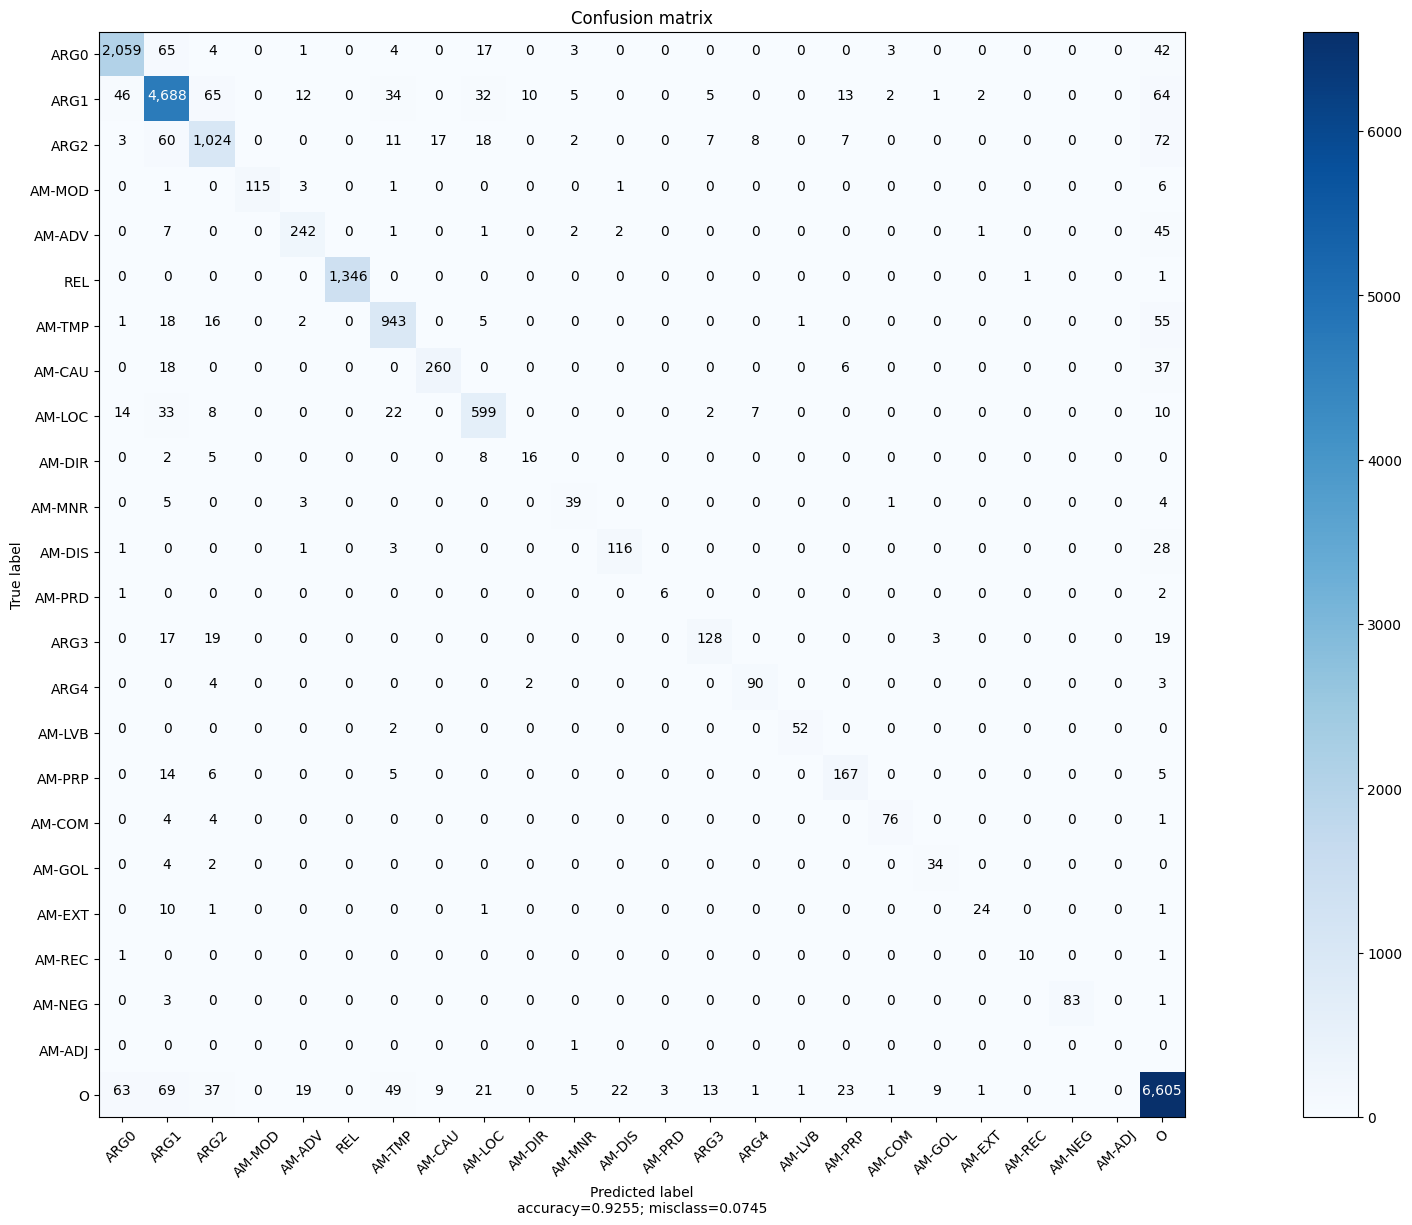

In [ ]:
# large english model with gozali data
xlmr_large_english_16_tester = TesterModel(configurations["xlmr_16"])
xlmr_large_english_16_tester.predict_data(test_gozali_data)

## Predicting

In [ ]:
class PredictModel():
    def __init__(self, config):
        self.model_dir = config["model_location"]
        self.pad_token_label_id = CrossEntropyLoss().ignore_index
        self.transformer_model: TransformerModel = TransformerModel(config)
        self.matrix_model = None
        self.pos_tag_model = pipeline("token-classification", model="w11wo/indonesian-roberta-base-posp-tagger")

    def preprocess_text(self,text):
        list_data = []
        list_tag = self.pos_tag_model(text)
        words = text.split(" ")
        for tag in list_tag:
            if tag["entity"] in configurations["default"]["verb_labels"]:
                labels = ["O" for i in range (len(words))]
                labels[tag["index"]] = "B-REL"
                srl = {
                "words" : words,
                "arguments" : labels,
                "predicate" : words[tag["index"]]
                }
                list_data.append(srl)
        return list_data

    def preprocess_index(self,text, index):
        list_data = []
        words = text.split(" ")
        for idx in index:
            labels = ["O" for i in range (len(words))]
            labels[idx] = "B-REL"
            srl = {
            "words" : words,
            "arguments" : labels,
            "predicate" : words[idx]
            }
            list_data.append(srl)
        return list_data

    def generate_label(self, teks, index_verb=None):
        self.matrix_model = MatrixModel()
        # Load Saved Model
        self.transformer_model.load_model(self.model_dir)
        model = self.transformer_model.model
        tokenizer =self.transformer_model.tokenizer
        label2index = self.transformer_model.build_label_vocab()
        index2label = {v: k for k, v in label2index.items()}
        if index_verb != None:
            data = self.preprocess_index(teks, index_verb)
        else:
            data = self.preprocess_text(teks)
        if len(data) == 0:
            print("Tidak ada predikat")
        else:
            # Load File for Predictions
            pred_dataloader = self.transformer_model.create_pred_dataloader(data)
            model.eval()
            total_sents = 0

            for batch in pred_dataloader:
                # Add batch to GPU
                batch = tuple(t.to(device) for t in batch)

                # Unpack the inputs from our dataloader
                b_input_ids, b_input_mask, b_labels, b_lengths, b_preds = batch
                with torch.no_grad():
                    outputs = model(b_input_ids, token_type_ids=b_preds, attention_mask=b_input_mask)
                logits = outputs[0]
                class_probabilities = torch.softmax(logits, dim=-1)

                # Move class_probabilities and labels to CPU
                class_probabilities = class_probabilities.detach().cpu().numpy()
                argmax_indices = np.argmax(class_probabilities, axis=-1)

                label_ids = b_labels.to('cpu').numpy()
                seq_lengths = b_lengths.to('cpu').numpy()

                for ix in range(len(label_ids)):
                    total_sents += 1
                    text = tokenizer.convert_ids_to_tokens(b_input_ids[ix])
                    # Store predictions and true labels
                    pred_labels = [index2label[p] for p in argmax_indices[ix][:seq_lengths[ix]]]
                    gold_labels = [index2label[g] for g in label_ids[ix]]
                    # Delete unnecessary label
                    idx_pad = text.index("<pad>")
                    pred_labels = pred_labels[1:len(pred_labels)-1]
                    gold_labels = gold_labels[1:idx_pad-1]
                    text = text[1:idx_pad-1]
                    _, pred_labels = self.matrix_model.filter_label(text, gold_labels, pred_labels)
                    print(f"\n----- {total_sents} -----\n{teks}\n{pred_labels}")


In [ ]:
# large english model with gozali data 32 batch
model_predict = PredictModel(configurations["xlmr_32"])
model_predict.generate_label("Lantas, sejumlah barang senilai ratusan juta yang dijual di toko itu dibawa kabur .", [8,12])

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



----- 1 -----
Lantas, sejumlah barang senilai ratusan juta yang dijual di toko itu dibawa kabur .
['B-AM-TMP', 'B-ARG1', 'I-ARG1', 'B-ARG3', 'I-ARG3', 'I-ARG3', 'O', 'O', 'B-AM-LOC', 'I-AM-LOC', 'I-AM-LOC', 'O', 'O', 'O']

----- 2 -----
Lantas, sejumlah barang senilai ratusan juta yang dijual di toko itu dibawa kabur .
['O', 'B-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'I-ARG1', 'O', 'B-REL', 'O']
